In [1]:
import scipy.io as sio
import numpy as np
from sklearn.cluster import KMeans

data = sio.loadmat('data.mat')

user_no = 0     # 指定用户（0-3636，一共3637名用户）
data_type = 1   # 0表示用户编号（没啥作用），1表示功率数据
print(data["customer"][0][user_no][data_type].shape)
    
# 创建一个空numpy数组
load = np.zeros((3637,24,171))

for user in range(3637):
    load[user] = np.array(data["customer"][0][user][data_type])
# 不共享内存的复制这个空numpy数组
load_0to1 = np.copy(load)
load_0to1[0].shape
# 0-1归一化处理每个用户数据
for user in range(3637):
    load_max = np.max(load_0to1[user])
    load_min = np.min(load_0to1[user])
    load_0to1[user] = (load_0to1[user]-load_min)/(load_max-load_min)
load_0to1[0].shape
load_user_feature_mean = np.zeros((3637, 24))
for user in range(3637):
    mean = np.mean(load_0to1[user], axis=1)
    load_user_feature_mean[user] = mean


(24, 171)


In [4]:
import scipy.io as sio
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
# 将numpy数组转换为pandas DataFrame
df = pd.DataFrame(load_user_feature_mean)

# 检查空缺值
print("空缺值数量：")
print(df.isnull().sum())

# 检查是否有无穷大或无穷小的值
print("\n无穷大或无穷小的值的数量：")
print(np.isinf(df).sum())

# 删除包含空缺值或无穷值的行
df_clean = df.replace([np.inf, -np.inf], np.nan).dropna()

# 输出清理前后的行数
print(f"\n原始数据行数: {df.shape[0]}")
print(f"清理后的数据行数: {df_clean.shape[0]}")

# 如果需要，将清理后的数据转回numpy数组
load_user_feature_mean_clean = df_clean.to_numpy()

print(f"\n清理后的数组形状: {load_user_feature_mean_clean.shape}")

空缺值数量：
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
dtype: int64

无穷大或无穷小的值的数量：
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
dtype: int64

原始数据行数: 3637
清理后的数据行数: 3637

清理后的数组形状: (3637, 24)


In [5]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
import seaborn as sns
from sklearn.cluster import KMeans

class EnergyFingerPrints():
     
    def __init__(self,data):
        # will contain the centroid of each cluster
        self.means = [] 
        self.data = data

    def elbow_method(self,n_clusters):
        """Performs elbow method for a predefined number
        of clusters.
        
        Parameters
        ----------
        n_clusters : int
            the number of clusters to perform the elbow method
        
        Returns
        ---------
        A plot the of elbow method
        """
        fig,ax=plt.subplots(figsize=(8,4)) 
        distortions = []

        for i in range(1, n_clusters):
            km = KMeans(n_clusters = i, 
                        init='k-means++', #初始中心簇的获取方式，k-means++一种比较快的收敛的方法
                        n_init=10,        #初始中心簇的迭代次数
                        max_iter=300,     #数据分类的迭代次数
                        random_state=0)   #初始化中心簇的方式
            km.fit(self.data)
            distortions.append(km.inertia_) #inertia计算样本点到最近的中心点的距离之和
        
        plt.plot(range(1,n_clusters), distortions, marker='o',lw=1)
        plt.xlabel('Number of clusters')
        plt.ylabel('Sum of distances to center')        
        plt.show() 
        
    def get_cluster_counts(self):
        return pd.Series(self.predictions).value_counts()
    
    def labels(self,n_clusters):
        self.n_clusters = n_clusters
        return KMeans(self.n_clusters, init='k-means++', n_init=10,max_iter=300,random_state=0).fit(self.data).labels_
        
    def fit(self,n_clusters):
        """Performs K-means clustering for the load-profiles
        
        Parameters
        ----------
        n_clusters : int
        
        Returns
        --------
        count_dict : dict
            The number of load-profiles in each cluster
        """
        self.n_clusters = n_clusters
        self.kmeans = KMeans(self.n_clusters)
        self.predictions = self.kmeans.fit_predict(self.data)

    
    def plot(self):
        """Plots all loads in each cluster"""
        
        self.cluster_names = [str(x) for x in range(self.n_clusters)]
        fig,ax=plt.subplots(figsize=(12,16))

        for i in range(0,self.n_clusters):
            all_data = [] 
            for x,y in zip(self.data,self.predictions):
                    if y == i:
                        all_data.append(x)
                        plt.subplot(4,1,i+1)
                        plt.plot(x,alpha=0.06,color="blue",lw=2)
                        plt.xlim(0,23)
                        plt.title('Cluster%s'%(i+1))
                        plt.ylabel('power/w')
                    
            all_data_array = np.array(all_data)
            mean = all_data_array.mean(axis=0)
            self.means.append(mean)
            plt.plot(mean, color="black",linewidth=4)
        
        plt.show()

        
    def plot_energy_fingerprints(self):
        """Plots the mean of each cluster in single plot"""
        fig,ax=plt.subplots(figsize=(12,6))
        
        for i,item in enumerate(self.means):
            plt.plot(item, label = "cluster %s"%(str(i+1)))
            plt.xlim(0,23)
        plt.ylabel('power/kW')
        plt.xticks(range(0, 24, 3),rotation=60)
        plt.grid()
        plt.legend()
        plt.show()

Exception in thread Thread-5 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\29623\anaconda3\envs\torch\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "c:\Users\29623\anaconda3\envs\torch\Lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\29623\anaconda3\envs\torch\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\29623\anaconda3\envs\torch\Lib\subprocess.py", line 1597, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb1 in position 29: invalid start byte
c:\Users\29623\anaconda3\envs\torch\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
'NoneType' object has no attribute 'splitlines'
Returning the number of

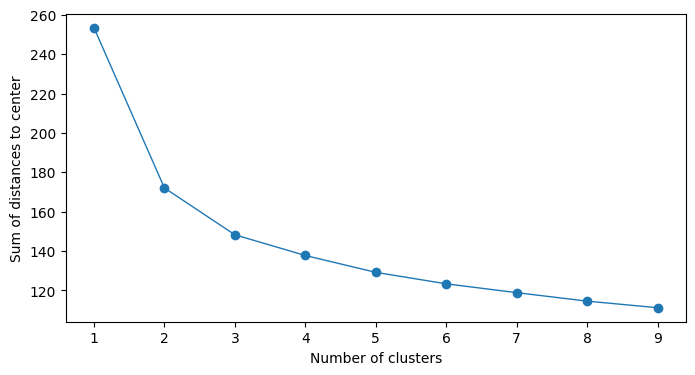

In [6]:
load_data=np.array(load_user_feature_mean)
energy_clusters = EnergyFingerPrints(load_data)
energy_clusters.elbow_method(n_clusters=10)

In [13]:
energy_clusters.fit(n_clusters=4)
energy_clusters.get_cluster_counts()
group = energy_clusters.labels(n_clusters=4)

# Extract user IDs from the original data structure
user_ids = [data["customer"][0][i][0][0] for i in range(3637)]

# Create a DataFrame with the user IDs and cluster labels
cls = pd.DataFrame({'user_id': user_ids, 'cluster': group})

# Sort the DataFrame by cluster labels
cls = cls.sort_values(by='cluster', ascending=True)
cls = cls.reset_index(drop=True)

print(cls['cluster'].value_counts())

cluster
3    1050
1    1012
2     880
0     695
Name: count, dtype: int64


c:\Users\29623\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=15.
  warnings.warn(
c:\Users\29623\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=15.
  warnings.warn(


Cluster 0 users:
[array([7442], dtype=uint16) array([5148], dtype=uint16)
 array([5145], dtype=uint16) array([5136], dtype=uint16)
 array([5123], dtype=uint16) array([2334], dtype=uint16)
 array([2335], dtype=uint16) array([5110], dtype=uint16)
 array([2346], dtype=uint16) array([5104], dtype=uint16)
 array([5102], dtype=uint16) array([5095], dtype=uint16)
 array([2356], dtype=uint16) array([2358], dtype=uint16)
 array([5077], dtype=uint16) array([2360], dtype=uint16)
 array([2369], dtype=uint16) array([2370], dtype=uint16)
 array([5075], dtype=uint16) array([2373], dtype=uint16)
 array([5072], dtype=uint16) array([5064], dtype=uint16)
 array([2394], dtype=uint16) array([5053], dtype=uint16)
 array([5048], dtype=uint16) array([2403], dtype=uint16)
 array([5149], dtype=uint16) array([5042], dtype=uint16)
 array([5151], dtype=uint16) array([5164], dtype=uint16)
 array([5316], dtype=uint16) array([5310], dtype=uint16)
 array([5296], dtype=uint16) array([5285], dtype=uint16)
 array([5283],

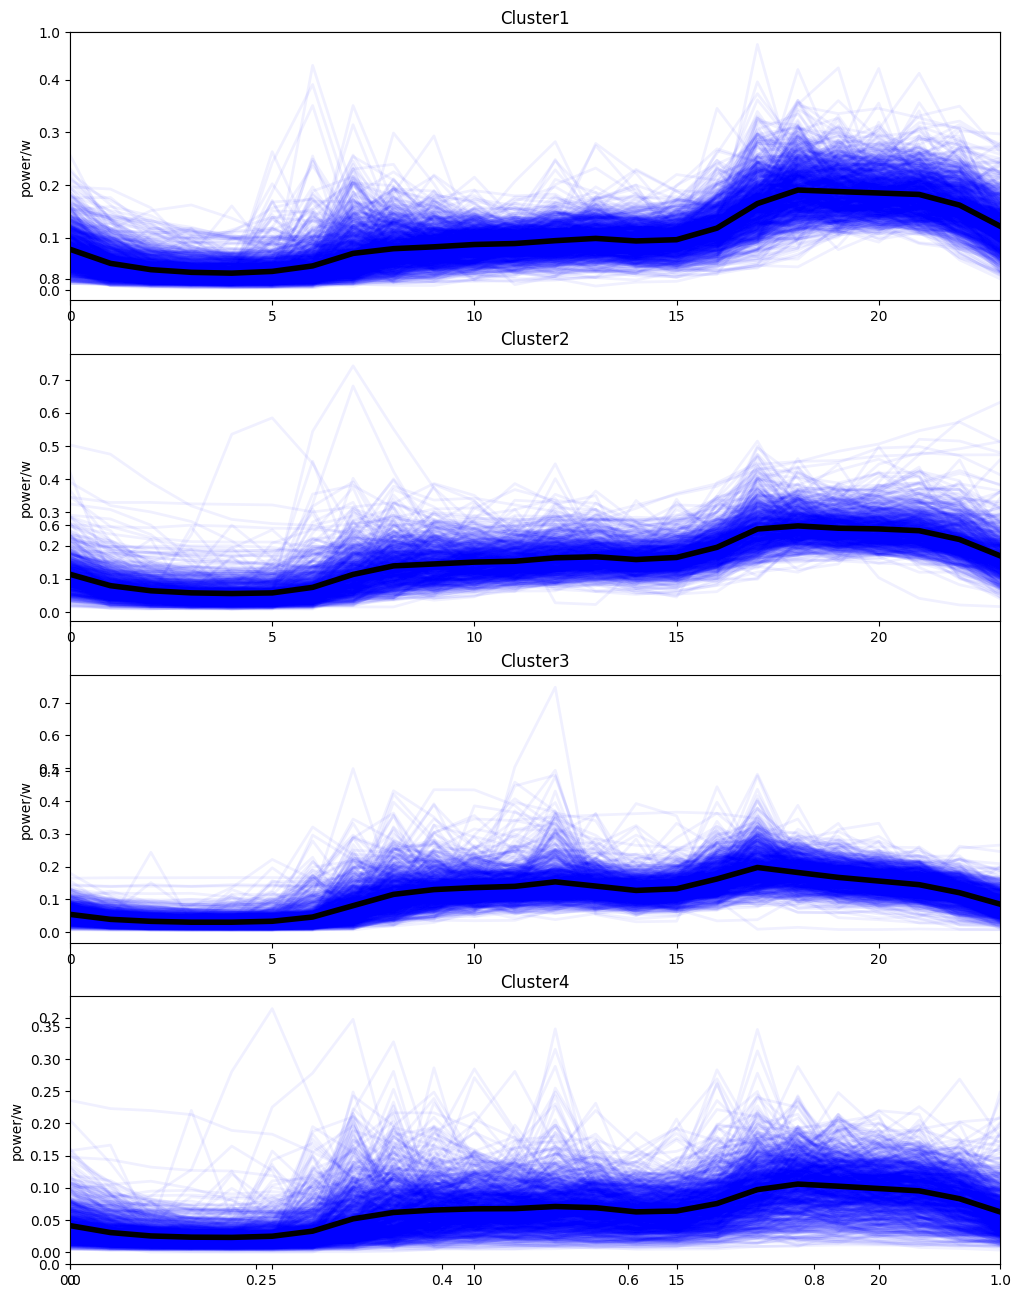

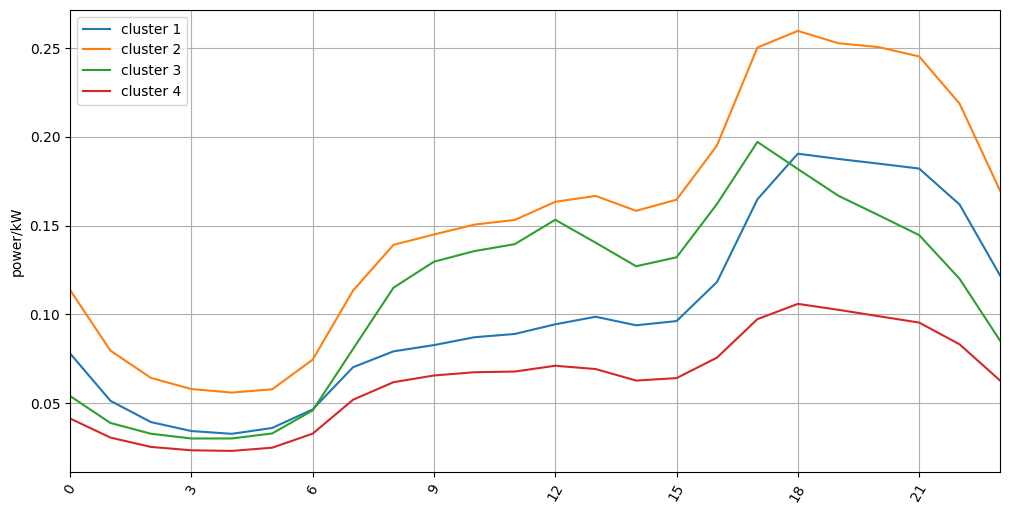

In [14]:
#获得每簇的用户id
for i in range(4): 
    cluster_users = np.array(cls.loc[cls.cluster == i].user_id)
    print(f"Cluster {i} users:")
    print(cluster_users)
    print()  # 空行，用于分隔不同簇的输出
#获取每簇用户的负荷曲线
energy_clusters.plot()
#获取每簇用户的平均负荷曲线
energy_clusters.plot_energy_fingerprints()

In [15]:
import numpy as np
from scipy import io
cluster_dict = {}
for i in range(4): 
        cluster_users = np.array(cls.loc[cls.cluster == i, 'user_id'])
        cluster_dict[f'cluster_{i+1}'] = cluster_users
io.savemat('cluster_users_dict.mat', cluster_dict)